# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 2: Tipping points and the Greenland ice sheet

Modelling the interplay between global temperatures and albedo affect to predict the melting of the greenland icesheet.


### Modelling Assumptions

- parabolic ice sheet cross section

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
# lets get some shit down

h = 3000        # height of ice sheeet (m)
P = 4           # precipitation rate (m/yr)
r = 1           # rate of melting (m/yr)
T_0 = 270       # pre-industrial surface temp (K)
d_T = 0         # change in temperature from global warming (function of t)
h_f = 0         # characteristic length, altitude above whcih the ice won't melt
F = 1           # rate of flow of ice sheet into the sea

# rate of change of height of ice sheet
def f(h, P, r, T_0, d_T, h_f, F):
    dh_dt = P - (r*(T_0+d_T))/(h+h_f)-(F*h)
    if h <= 0 and dh_dt < 0:
        dh_dt = 0
    return dh_dt


In [ ]:
# lets define how surface temperature changes over time
alpha = 0.3         # albedo effect
beta = 0.4          # greenhouse effect
betastar = 0.01     # man-made greenhouse effect
sigma = 5.67e-8     # Stefan-Boltzmann constant
R_in = 340          # incoming solar energy (W/m^2)


def T(alpha, R_in, beta, betastar, sigma, T_0):
    d_T = ((1-alpha)*R_in / (1-(beta+betastar))/sigma)**0.25 - T_0
    return d_T

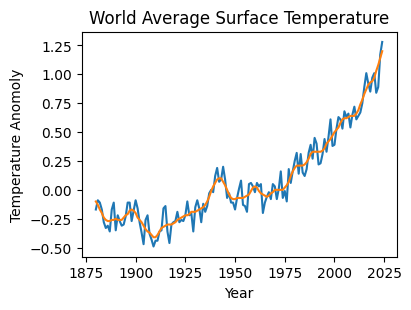

In [10]:
with open("temperature.txt", "r") as file:
    lines = file.readlines()  # Read all lines into a list

# get rid of initial headers
lines = lines[5:len(lines)]

# Process each line
data = [line.strip().split() for line in lines]  # Removes '\n' and splits by space
processed_data = [[int(line[0]), float(line[1]), float(line[2])] for line in data]

# putting into a np array
NASAtemp = np.array(processed_data)
# print(np.shape(NASAtemp))

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_axes([0.10, 0.15, 0.35, 0.75])
ax1.plot(NASAtemp[:,0], NASAtemp[:,1])
ax1.plot(NASAtemp[:,0], NASAtemp[:,2])
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomoly')
ax1.set_title('World Average Surface Temperature')
plt.show()

In [ ]:
# we also want how betastar changes with time
# assuming emissions increase linearly
gamma = 2           # rate of linear emissions (to be calibrated)
def get_E(t, gamma):
    E_1950 = 5.2e9      # CO2 emissions in 1950 (tonnes)
    E = gamma*(t-1950)+E_1950
    return E

t = np.linspace(1950, 2000, 100)
# E_arr = np.array([])
E_arr = get_E(t, gamma)

# how emissions relate to CO2 air density
def drho_dt(E, rho):
    kappa = 2           # coefficient (to be calibrated)
    t_CO2 = 100         # life span of CO2 in atmosphere (years)
    rho_1950 = 315      # technically 1959 (ppm)
    return kappa*E - (1/t_CO2)*(rho-rho_1950)

rho = solve_ivp(drho_dt, [0, 200], [h01], t_eval=t)

# how CO2 air density relates to betastar

G = 1               # proportionality constant (to be calibrated)
betastar = G*rho

NameError: name 'rho' is not defined